<a href="https://colab.research.google.com/github/surajpandey11/capstone-project-3--news-prediction/blob/main/Copy_of_News_Popularity_Prediction_in_Social_Media_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting the news popularity in multiple social media platforms. </u></b>

## <b> Problem Description </b>

### This is a large data set of news items and their respective social feedback on multiple platforms: Facebook, Google+ and LinkedIn.The collected data relates to a period of 8 months, between November 2015 and July 2016, accounting for about 100,000 news items on four different topics: Economy, Microsoft, Obama and Palestine.


## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### IDLink (numeric): Unique identifier of news items
* ### Title (string): Title of the news item according to the official media sources
* ### Headline (string): Headline of the news item according to the official media sources
* ### Source (string): Original news outlet that published the news item
* ### Topic (string): Query topic used to obtain the items in the official media sources
* ### PublishDate (timestamp): Date and time of the news items' publication
* ### SentimentTitle (numeric): Sentiment score of the text in the news items' title
* ### SentimentHeadline (numeric): Sentiment score of the text in the news items' headline
* ### Facebook (numeric): Final value of the news items' popularity according to the social media source Facebook
* ### GooglePlus (numeric): Final value of the news items' popularity according to the social media source Google+
* ### LinkedIn (numeric): Final value of the news items' popularity according to the social media source LinkedIn


### VARIABLES OF SOCIAL FEEDBACK DATA

* ### IDLink (numeric): Unique identifier of news items
* ### TS1 (numeric): Level of popularity in time slice 1 (0-20 minutes upon publication)
* ### TS2 (numeric): Level of popularity in time slice 2 (20-40 minutes upon publication)
* ### TS... (numeric): Level of popularity in time slice ...
* ### TS144 (numeric): Final level of popularity after 2 days upon publication

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from spacy.lang.en import English
from spacy.lang.en.stop_words import stopword
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer

import string
punctuations = string.punctuation
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn import decomposition
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
news=pd.read_csv('/content/drive/MyDrive/AlmaBetter/Module 4/Week 2/Day 1/Copy of News_Final.csv')

In [ ]:
news.head()


,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


In [ ]:
news=news.iloc[:40000,:]

In [ ]:
news.shape


(40000, 11)

In [ ]:
news.Headline[0]

'Obama Lays Wreath at Arlington National Cemetery. President Barack Obama has laid a wreath at the Tomb of the Unknowns to honor'

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


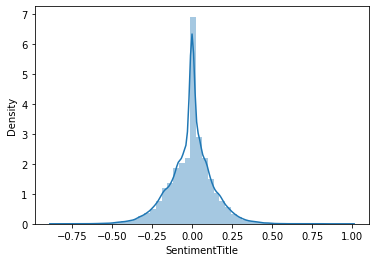

In [ ]:
sns.distplot(news['SentimentTitle'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


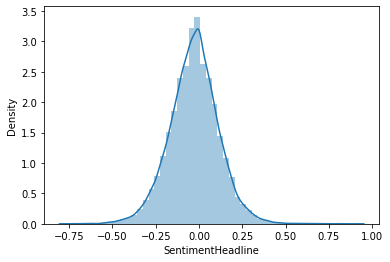

In [ ]:
sns.distplot(news['SentimentHeadline'])

In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             40000 non-null  float64
 1   Title              40000 non-null  object 
 2   Headline           39996 non-null  object 
 3   Source             39883 non-null  object 
 4   Topic              40000 non-null  object 
 5   PublishDate        40000 non-null  object 
 6   SentimentTitle     40000 non-null  float64
 7   SentimentHeadline  40000 non-null  float64
 8   Facebook           40000 non-null  int64  
 9   GooglePlus         40000 non-null  int64  
 10  LinkedIn           40000 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 3.4+ MB


In [ ]:
news.Title[0]

'Obama Lays Wreath at Arlington National Cemetery'

In [ ]:
news.Facebook.value_counts()

 0        7952
 1        3007
-1        2803
 2        2231
 3        1587
          ... 
 1073        1
 1201        1
 3280        1
 15606       1
 3790        1
Name: Facebook, Length: 1934, dtype: int64

In [ ]:
news.GooglePlus.value_counts()

 0      21518
 1       4500
-1       2743
 2       2318
 3       1447
        ...  
 371        1
 137        1
 243        1
 211        1
 176        1
Name: GooglePlus, Length: 258, dtype: int64

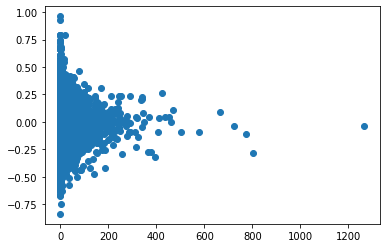

In [ ]:
plt.scatter(x=news['GooglePlus'],y=news['SentimentTitle'])

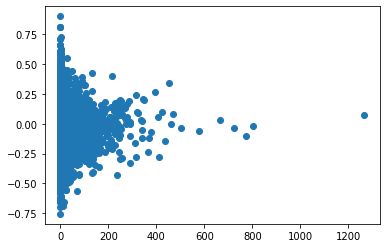

In [ ]:
plt.scatter(x=news['GooglePlus'],y=news['SentimentHeadline'])

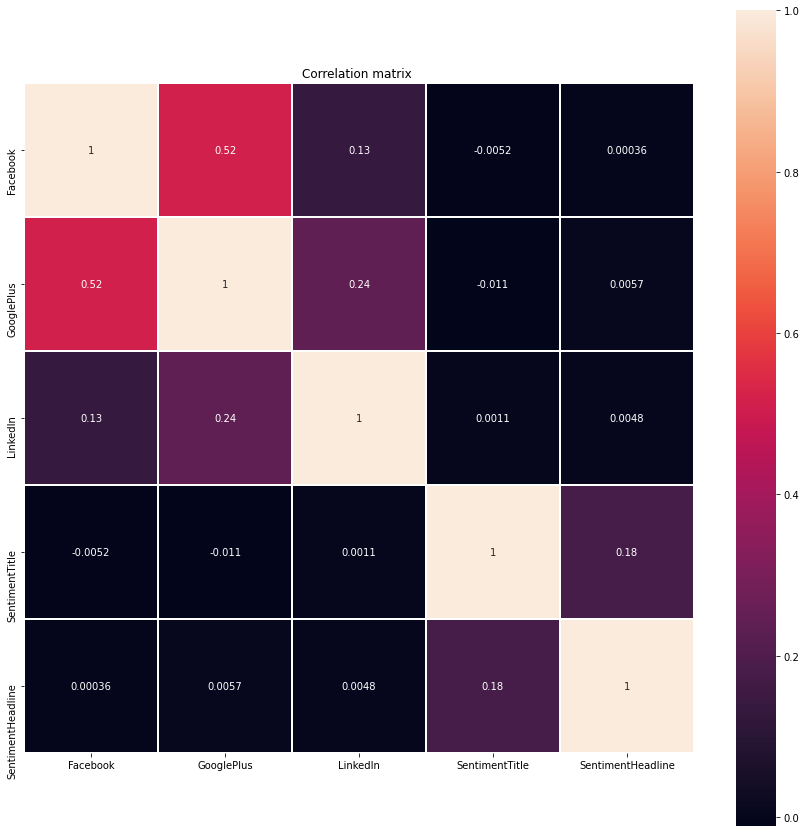

In [ ]:
plt.figure(figsize=(15,15))
_ = sns.heatmap(news[['Facebook','GooglePlus','LinkedIn','SentimentTitle','SentimentHeadline']].corr(), square=True,linewidths=0.5,linecolor='w',annot=True)
plt.title('Correlation matrix ')

plt.show()

In [ ]:
missing_val = pd.DataFrame(news.isnull().sum())

missing_val = missing_val.reset_index()
missing_val

,index,0
0,IDLink,0
1,Title,0
2,Headline,4
3,Source,117
4,Topic,0
5,PublishDate,0
6,SentimentTitle,0
7,SentimentHeadline,0
8,Facebook,0
9,GooglePlus,0


In [ ]:
news['Source'].value_counts()

Bloomberg                715
Reuters                  550
ABC News                 454
Business Insider         435
New York Times           410
                        ... 
XDA Developers (blog)      1
KUTV 2News                 1
CBS 5 Phoenix              1
SQL Server Pro (blog)      1
Fund Strategy              1
Name: Source, Length: 4064, dtype: int64

In [ ]:
news['Topic'].value_counts()

economy      14827
obama        11846
microsoft     9339
palestine     3988
Name: Topic, dtype: int64

In [ ]:
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
news.dropna(inplace=True)

In [ ]:
cols = ['Title', 'Headline']
news['combined'] = news[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [ ]:
news

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,combined
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1,Obama Lays Wreath at Arlington National Cemete...
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1,A Look at the Health of the Chinese Economy_Ti...
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1,Nouriel Roubini: Global Economy Not Back to 20...
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1,Finland GDP Expands In Q4_Finland's economy ex...
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1,"Tourism, govt spending buoys Thai economy in J..."
...,...,...,...,...,...,...,...,...,...,...,...,...
39995,78868.0,Obama: No Excuse For GOP Not To Vote On A Cour...,President Barack Obama declared Tuesday that R...,CBS San Francisco,obama,2016-02-16 16:41:00,0.204478,0.067798,-1,-1,-1,Obama: No Excuse For GOP Not To Vote On A Cour...
39996,24947.0,"Microsoft Patents a Modular PC, Get Netflix Pa...","Microsoft wants you to build modular PCs, Netf...",MakeUseOf,microsoft,2016-02-16 16:41:31,-0.105673,-0.066734,8,4,1,"Microsoft Patents a Modular PC, Get Netflix Pa..."
39997,78366.0,Obama Urges Senate To Act On Court Nominee Des...,President Barack Obama on Tuesday vowed to pic...,Malaysian Digest,obama,2016-02-16 16:42:00,-0.188445,0.046875,0,0,0,Obama Urges Senate To Act On Court Nominee Des...
39998,78899.0,Obama calls for ‘tangible steps’ to lower Sout...,RANCHO MIRAGE: President Barack Obama on Tuesd...,Free Malaysia Today,obama,2016-02-16 16:45:00,0.094222,0.151598,-1,-1,-1,Obama calls for ‘tangible steps’ to lower Sout...


In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39879 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             39879 non-null  float64
 1   Title              39879 non-null  object 
 2   Headline           39879 non-null  object 
 3   Source             39879 non-null  object 
 4   Topic              39879 non-null  object 
 5   PublishDate        39879 non-null  object 
 6   SentimentTitle     39879 non-null  float64
 7   SentimentHeadline  39879 non-null  float64
 8   Facebook           39879 non-null  int64  
 9   GooglePlus         39879 non-null  int64  
 10  LinkedIn           39879 non-null  int64  
 11  combined           39879 non-null  object 
dtypes: float64(3), int64(3), object(6)
memory usage: 4.0+ MB


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import string
from nltk.corpus import stopwords

In [ ]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
[punc for punc in string.punctuation]

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

In [ ]:
def text_process(msg):
    nopunc =[char for char in msg if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

In [ ]:
news['combined1']=news['combined'].apply(text_process)

In [ ]:
def clean(s):
  s = s.lower()
  # Change 't to 'not'
  s = re.sub(r"\'t", " not", s)
  # Remove @name
  s = re.sub(r'(@.*?)[\s]', ' ', s)
  # Isolate and remove punctuations except '?'
  s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
  s = re.sub(r'[^\w\s\?]', ' ', s)
  # Remove some special characters
  s = re.sub(r'([\;\:\|•«\n])', ' ', s)
  # Remove stopwords except 'not' and 'can'
  s = " ".join([word for word in s.split()
                if word not in stopwords.words('english')
                or word in ['not', 'can']])
  # Remove trailing whitespace
  s = re.sub(r'\s+', ' ', s).strip()
  
  return s

In [ ]:
news['combined2']=news['combined'].apply(clean)

In [ ]:
news

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,combined,combined1,combined2
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1,Obama Lays Wreath at Arlington National Cemete...,Obama Lays Wreath Arlington National CemeteryO...,obama lays wreath arlington national cemetery_...
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1,A Look at the Health of the Chinese Economy_Ti...,Look Health Chinese EconomyTim Haywood investm...,look health chinese economy_tim haywood invest...
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1,Nouriel Roubini: Global Economy Not Back to 20...,Nouriel Roubini Global Economy Back 2008Nourie...,nouriel roubini global economy not back 2008_n...
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1,Finland GDP Expands In Q4_Finland's economy ex...,Finland GDP Expands Q4Finlands economy expande...,finland gdp expands q4_finland economy expande...
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1,"Tourism, govt spending buoys Thai economy in J...",Tourism govt spending buoys Thai economy Janua...,tourism govt spending buoys thai economy janua...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,78868.0,Obama: No Excuse For GOP Not To Vote On A Cour...,President Barack Obama declared Tuesday that R...,CBS San Francisco,obama,2016-02-16 16:41:00,0.204478,0.067798,-1,-1,-1,Obama: No Excuse For GOP Not To Vote On A Cour...,Obama Excuse GOP Vote Court NomineePresident B...,obama excuse gop not vote court nominee_presid...
39996,24947.0,"Microsoft Patents a Modular PC, Get Netflix Pa...","Microsoft wants you to build modular PCs, Netf...",MakeUseOf,microsoft,2016-02-16 16:41:31,-0.105673,-0.066734,8,4,1,"Microsoft Patents a Modular PC, Get Netflix Pa...",Microsoft Patents Modular PC Get Netflix Passw...,microsoft patents modular pc get netflix passw...
39997,78366.0,Obama Urges Senate To Act On Court Nominee Des...,President Barack Obama on Tuesday vowed to pic...,Malaysian Digest,obama,2016-02-16 16:42:00,-0.188445,0.046875,0,0,0,Obama Urges Senate To Act On Court Nominee Des...,Obama Urges Senate Act Court Nominee Despite W...,obama urges senate act court nominee despite w...
39998,78899.0,Obama calls for ‘tangible steps’ to lower Sout...,RANCHO MIRAGE: President Barack Obama on Tuesd...,Free Malaysia Today,obama,2016-02-16 16:45:00,0.094222,0.151598,-1,-1,-1,Obama calls for ‘tangible steps’ to lower Sout...,Obama calls ‘tangible steps’ lower South China...,obama calls tangible steps lower south china s...


In [ ]:
from spacy.lang.en import English

In [ ]:
nlp = English()

In [ ]:
def spacy_tok(sen):
  mytokens = nlp(sen)

  mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

  mytokens = [ word for word in mytokens if word not in STOP_WORDS and word not in string.punctuation ]

  return ' '.join(mytokens)
# 

In [ ]:
news['tokenized'] = news['combined2'].apply(spacy_tok)

In [ ]:
def spacy_tokenizer(sentence):
    
    my_doc = nlp(sentence)

    # Create list of word tokens
    token_list = []
    for token in my_doc:
        token_list.append(token.text)

    from spacy.lang.en.stop_words import STOP_WORDS

    # Create list of word tokens after removing stopwords
    filtered_sentence =[] 

    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word) 
    return filtered_sentence
    # print(token_list)
    # print(filtered_sentence) 

In [ ]:
news['tokenized_message'] = news['combined2'].apply(spacy_tokenizer)

In [ ]:
# import re
# def pre_process(text):
    
#     # lowercase
#     text=text.lower()
    
#     #remove tags
#     text=re.sub("","",text)
    
#     # remove special characters and digits
#     text=re.sub("(\\d|\\W)+"," ",text)
    
#     return text

# news['text'] = news['tokenized_message'] 
# news['text'] = news['text'].apply(lambda x:pre_process(x))

# #show the second 'text' just for fun
# news['text'][2]

In [ ]:
news

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,combined,combined1,combined2,tokenized,tokenized_message
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1,Obama Lays Wreath at Arlington National Cemete...,Obama Lays Wreath Arlington National CemeteryO...,obama lays wreath arlington national cemetery_...,obama lays wreath arlington national cemetery_...,"[obama, lays, wreath, arlington, national, cem..."
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1,A Look at the Health of the Chinese Economy_Ti...,Look Health Chinese EconomyTim Haywood investm...,look health chinese economy_tim haywood invest...,look health chinese economy_tim haywood invest...,"[look, health, chinese, economy_tim, haywood, ..."
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1,Nouriel Roubini: Global Economy Not Back to 20...,Nouriel Roubini Global Economy Back 2008Nourie...,nouriel roubini global economy not back 2008_n...,nouriel roubini global economy 2008_nouriel ro...,"[nouriel, roubini, global, economy, 2008_nouri..."
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1,Finland GDP Expands In Q4_Finland's economy ex...,Finland GDP Expands Q4Finlands economy expande...,finland gdp expands q4_finland economy expande...,finland gdp expands q4_finland economy expande...,"[finland, gdp, expands, q4_finland, economy, e..."
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1,"Tourism, govt spending buoys Thai economy in J...",Tourism govt spending buoys Thai economy Janua...,tourism govt spending buoys thai economy janua...,tourism govt spending buoys thai economy janua...,"[tourism, govt, spending, buoys, thai, economy..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,78868.0,Obama: No Excuse For GOP Not To Vote On A Cour...,President Barack Obama declared Tuesday that R...,CBS San Francisco,obama,2016-02-16 16:41:00,0.204478,0.067798,-1,-1,-1,Obama: No Excuse For GOP Not To Vote On A Cour...,Obama Excuse GOP Vote Court NomineePresident B...,obama excuse gop not vote court nominee_presid...,obama excuse gop vote court nominee_president ...,"[obama, excuse, gop, vote, court, nominee_pres..."
39996,24947.0,"Microsoft Patents a Modular PC, Get Netflix Pa...","Microsoft wants you to build modular PCs, Netf...",MakeUseOf,microsoft,2016-02-16 16:41:31,-0.105673,-0.066734,8,4,1,"Microsoft Patents a Modular PC, Get Netflix Pa...",Microsoft Patents Modular PC Get Netflix Passw...,microsoft patents modular pc get netflix passw...,microsoft patents modular pc netflix passwords...,"[microsoft, patents, modular, pc, netflix, pas..."
39997,78366.0,Obama Urges Senate To Act On Court Nominee Des...,President Barack Obama on Tuesday vowed to pic...,Malaysian Digest,obama,2016-02-16 16:42:00,-0.188445,0.046875,0,0,0,Obama Urges Senate To Act On Court Nominee Des...,Obama Urges Senate Act Court Nominee Despite W...,obama urges senate act court nominee despite w...,obama urges senate act court nominee despite w...,"[obama, urges, senate, act, court, nominee, de..."
39998,78899.0,Obama calls for ‘tangible steps’ to lower Sout...,RANCHO MIRAGE: President Barack Obama on Tuesd...,Free Malaysia Today,obama,2016-02-16 16:45:00,0.094222,0.151598,-1,-1,-1,Obama calls for ‘tangible steps’ to lower Sout...,Obama calls ‘tangible steps’ lower South China...,obama calls tangible steps 

In [ ]:
#  nltk.download()

In [ ]:
# nltk.download('averaged_perceptron_tagger')

In [ ]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

news['comments_lemmatized'] = news["combined2"].apply(lemmatize_text)


In [ ]:
news

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,combined,combined1,combined2,tokenized,tokenized_message,comments_lemmatized
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1,Obama Lays Wreath at Arlington National Cemete...,Obama Lays Wreath Arlington National CemeteryO...,obama lays wreath arlington national cemetery_...,obama lays wreath arlington national cemetery_...,"[obama, lays, wreath, arlington, national, cem...","[o, b, a, m, a, , l, a, y, s, , w, r, e, a, ..."
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1,A Look at the Health of the Chinese Economy_Ti...,Look Health Chinese EconomyTim Haywood investm...,look health chinese economy_tim haywood invest...,look health chinese economy_tim haywood invest...,"[look, health, chinese, economy_tim, haywood, ...","[l, o, o, k, , h, e, a, l, t, h, , c, h, i, ..."
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1,Nouriel Roubini: Global Economy Not Back to 20...,Nouriel Roubini Global Economy Back 2008Nourie...,nouriel roubini global economy not back 2008_n...,nouriel roubini global economy 2008_nouriel ro...,"[nouriel, roubini, global, economy, 2008_nouri...","[n, o, u, r, i, e, l, , r, o, u, b, i, n, i, ..."
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1,Finland GDP Expands In Q4_Finland's economy ex...,Finland GDP Expands Q4Finlands economy expande...,finland gdp expands q4_finland economy expande...,finland gdp expands q4_finland economy expande...,"[finland, gdp, expands, q4_finland, economy, e...","[f, i, n, l, a, n, d, , g, d, p, , e, x, p, ..."
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1,"Tourism, govt spending buoys Thai economy in J...",Tourism govt spending buoys Thai economy Janua...,tourism govt spending buoys thai economy janua...,tourism govt spending buoys thai economy janua...,"[tourism, govt, spending, buoys, thai, economy...","[t, o, u, r, i, s, m, , g, o, v, t, , s, p, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,78868.0,Obama: No Excuse For GOP Not To Vote On A Cour...,President Barack Obama declared Tuesday that R...,CBS San Francisco,obama,2016-02-16 16:41:00,0.204478,0.067798,-1,-1,-1,Obama: No Excuse For GOP Not To Vote On A Cour...,Obama Excuse GOP Vote Court NomineePresident B...,obama excuse gop not vote court nominee_presid...,obama excuse gop vote court nominee_president ...,"[obama, excuse, gop, vote, court, nominee_pres...","[o, b, a, m, a, , e, x, c, u, s, e, , g, o, ..."
39996,24947.0,"Microsoft Patents a Modular PC, Get Netflix Pa...","Microsoft wants you to build modular PCs, Netf...",MakeUseOf,microsoft,2016-02-16 16:41:31,-0.105673,-0.066734,8,4,1,"Microsoft Patents a Modular PC, Get Netflix Pa...",Microsoft Patents Modular PC Get Netflix Passw...,microsoft patents modular pc get netflix passw...,microsoft patents modular pc netflix passwords...,"[microsoft, patents, modular, pc, netflix, pas...","[m, i, c, r, o, s, o, f, t, , p, a, t, e, n, ..."
39997,78366.0,Obama Urges Senate To Act On Court Nominee Des...,President Barack Obama on Tuesday vowed to pic...,Malaysian Digest,obama,2016-02-16 16:42:00,-0.188445,0.046875,0,0,0,Obama Urges Senate To Act On Court Nominee Des...,Obama Urges Senate Act Court Nominee Despite W...,obama urges senate act court nominee despite w...,obama urges senate act court nominee des

In [ ]:
 from nltk.stem import WordNetLemmatizer 

In [ ]:
# lemmatization
lem = WordNetLemmatizer()
def lem_word(x):
    return [lem.lemmatize(w) for w in x]

In [ ]:
news['text'] = news['tokenized_message'].apply(lemmatize_text)

In [ ]:
news

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,combined,combined1,combined2,tokenized,tokenized_message,comments_lemmatized,text
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1,Obama Lays Wreath at Arlington National Cemete...,Obama Lays Wreath Arlington National CemeteryO...,obama lays wreath arlington national cemetery_...,obama lays wreath arlington national cemetery_...,"[obama, lays, wreath, arlington, national, cem...","[o, b, a, m, a, , l, a, y, s, , w, r, e, a, ...","[obama, lay, wreath, arlington, national, ceme..."
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1,A Look at the Health of the Chinese Economy_Ti...,Look Health Chinese EconomyTim Haywood investm...,look health chinese economy_tim haywood invest...,look health chinese economy_tim haywood invest...,"[look, health, chinese, economy_tim, haywood, ...","[l, o, o, k, , h, e, a, l, t, h, , c, h, i, ...","[look, health, chinese, economy_tim, haywood, ..."
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1,Nouriel Roubini: Global Economy Not Back to 20...,Nouriel Roubini Global Economy Back 2008Nourie...,nouriel roubini global economy not back 2008_n...,nouriel roubini global economy 2008_nouriel ro...,"[nouriel, roubini, global, economy, 2008_nouri...","[n, o, u, r, i, e, l, , r, o, u, b, i, n, i, ...","[nouriel, roubini, global, economy, 2008_nouri..."
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1,Finland GDP Expands In Q4_Finland's economy ex...,Finland GDP Expands Q4Finlands economy expande...,finland gdp expands q4_finland economy expande...,finland gdp expands q4_finland economy expande...,"[finland, gdp, expands, q4_finland, economy, e...","[f, i, n, l, a, n, d, , g, d, p, , e, x, p, ...","[finland, gdp, expands, q4_finland, economy, e..."
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1,"Tourism, govt spending buoys Thai economy in J...",Tourism govt spending buoys Thai economy Janua...,tourism govt spending buoys thai economy janua...,tourism govt spending buoys thai economy janua...,"[tourism, govt, spending, buoys, thai, economy...","[t, o, u, r, i, s, m, , g, o, v, t, , s, p, ...","[tourism, govt, spending, buoy, thai, economy,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,78868.0,Obama: No Excuse For GOP Not To Vote On A Cour...,President Barack Obama declared Tuesday that R...,CBS San Francisco,obama,2016-02-16 16:41:00,0.204478,0.067798,-1,-1,-1,Obama: No Excuse For GOP Not To Vote On A Cour...,Obama Excuse GOP Vote Court NomineePresident B...,obama excuse gop not vote court nominee_presid...,obama excuse gop vote court nominee_president ...,"[obama, excuse, gop, vote, court, nominee_pres...","[o, b, a, m, a, , e, x, c, u, s, e, , g, o, ...","[obama, excuse, gop, vote, court, nominee_pres..."
39996,24947.0,"Microsoft Patents a Modular PC, Get Netflix Pa...","Microsoft wants you to build modular PCs, Netf...",MakeUseOf,microsoft,2016-02-16 16:41:31,-0.105673,-0.066734,8,4,1,"Microsoft Patents a Modular PC, Get Netflix Pa...",Microsoft Patents Modular PC Get Netflix Passw...,microsoft patents modular pc get netflix passw...,microsoft patents modular pc netflix passwords...,"[microsoft, patents, modular, pc, netflix, pas...","[m, i, c, r, o, s, o, f, t, , p, a, t, e, n, ...","[microsoft, patent, modular, pc, netflix, pass..."

In [ ]:
df = news[(news['LinkedIn'] != -1)]

In [ ]:
df

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,combined,combined1,combined2,tokenized,tokenized_message,comments_lemmatized,text
726,311.0,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,microsoft,2015-11-08 05:25:00,0.000000,-0.132812,0,0,0,Microsoft offering £100 discount on original B...,Microsoft offering £100 discount original Band...,microsoft offering 100 discount original band ...,microsoft offering 100 discount original band ...,"[microsoft, offering, 100, discount, original,...","[m, i, c, r, o, s, o, f, t, , o, f, f, e, r, ...","[microsoft, offering, 100, discount, original,..."
727,252.0,Economy to improve though no change in last 6 ...,"&quot;In the coming six months, there seems to...",IANS India Private Limited/Yahoo India News vi...,economy,2015-11-08 05:40:00,-0.082022,0.205537,0,0,0,Economy to improve though no change in last 6 ...,Economy improve though change last 6 months As...,economy improve though change last 6 months as...,economy improve change 6 months assocham quot ...,"[economy, improve, change, 6, months, assocham...","[e, c, o, n, o, m, y, , i, m, p, r, o, v, e, ...","[economy, improve, change, 6, month, assocham,..."
728,227.0,Economy to improve though no change in last 6 ...,"New Delhi, Nov 8 (IANS) Majority of Indian bus...",IANS via Yahoo Maktoob News,economy,2015-11-08 05:48:00,-0.082022,0.186968,0,0,0,Economy to improve though no change in last 6 ...,Economy improve though change last 6 months As...,economy improve though change last 6 months as...,economy improve change 6 months assocham_new d...,"[economy, improve, change, 6, months, assocham...","[e, c, o, n, o, m, y, , i, m, p, r, o, v, e, ...","[economy, improve, change, 6, month, assocham_..."
729,307.0,Microsoft scales back free online storage plans,NEW YORK — Microsoft is getting stingy with on...,The Columbian,microsoft,2015-11-08 06:54:00,0.106303,-0.207333,0,0,0,Microsoft scales back free online storage plan...,Microsoft scales back free online storage plan...,microsoft scales back free online storage plan...,microsoft scales free online storage plans_new...,"[microsoft, scales, free, online, storage, pla...","[m, i, c, r, o, s, o, f, t, , s, c, a, l, e, ...","[microsoft, scale, free, online, storage, plan..."
730,207.0,IDC predicts the emergence of ‘DX economy’,KUCHING: The global digital economy is about t...,The Borneo Post,economy,2015-11-08 08:34:00,0.000000,0.003189,1,0,0,IDC predicts the emergence of ‘DX economy’_KUC...,IDC predicts emergence ‘DX economy’KUCHING glo...,idc predicts emergence dx economy _kuching glo...,idc predicts emergence dx economy kuching glob...,"[idc, predicts, emergence, dx, economy, _, kuc...","[i, d, c, , p, r, e, d, i, c, t, s, , e, m, ...","[idc, predicts, emergence, dx, economy, _, kuc..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39993,78248.0,Ted Cruz Assails Obama for 'Years of Neglect' ...,"""""""If there is a silver lining in the Obama-Cl...",ABC News,obama,2016-02-16 16:38:02,0.000000,-0.229272,496,19,1,Ted Cruz Assails Obama for 'Years of Neglect' ...,Ted Cruz Assails Obama Years Neglect US Milita...,ted cruz assails obama years neglect us milita...,ted cruz assails obama years neglect military ...,"[ted, cruz, assails, obama, years, neglect, mi...","[t, e, d, , c, r, u, z, , a, s, s, a, i, l, ...","[ted, cruz, assails, obama, year, neglect, mil..."
39994,78391.0,Obama Vows Help to Counter China in Southeast ...,President Barack Obama promised to help allies...,The Wall Street Journal,obama,2016-02-16 16:39:00,0.194444,0.124367,16,1,0,Obama Vows Help to Counter China in Southeast ...,Obama Vows Help Counter China Southeast AsiaPr...,obama vows help counter china southeast asia_p...,obama vows help counter china southeast asia_p...,"[obama, vows, help, counter, china, southeast,...","[o, b, a,

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# vect = TfidfVectorizer(sublinear_tf=True, max_df=0.5, analyzer='word', stop_words='english')

# X = vect.fit_transform(df.pop('text')).toarray()

# r = df[['SentimentTitle']].copy()

# del df

# df = pd.DataFrame(X, columns=vect.get_feature_names())

# del X
# del vect

# r.join(df)


In [ ]:
# news['tokenized_message_headlines'] = news['Headline'].apply(text_process)

In [ ]:
# news

In [ ]:
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

In [ ]:

df['text'] = df['text'].apply(lambda x : combine_text(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df

In [ ]:
import re
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("","",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

df['text'] = df['text'] 
df['text'] = df['text'].apply(lambda x:pre_process(x))

#show the second 'text' just for fun
df['text']

In [ ]:
df

In [ ]:
 from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(min_df=15,max_df=.50,max_features=1000,analyzer='word', 
                              token_pattern=r'\b[a-zA-Z]{3,}\b',  
                              ngram_range=(2, 2))
# X = vectorizer.fit_transform(df['text'])
vectorized = vectorizer.fit_transform(df['text'])

df1=pd.DataFrame(vectorized.toarray(), 
             index=['sentence '+str(i) 
                    for i in range(1, 1+len(df['text']))],
             columns=vectorizer.get_feature_names())
X = vectorizer.fit_transform(df['text'])

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
df1 = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [ ]:
df1


,according microsoft,according new,according report,action gun,added job,address nation,address president,address tuesday,administration official,administration plan,affair minister,affordable care,africa economy,ailing economy,alberta economy,amazon microsoft,american economy,american people,amid global,android apps,announced new,announced plan,announced tuesday,annual rate,anti muslim,antonin scalia,app microsoft,app store,apple ipad,apple microsoft,artificial intelligence,arun jaitley,asia pacific,asian leader,asian nation,ask congress,associated press,attack paris,attack president,attorney general,...,window store,window update,window upgrade,window user,window window,word flow,world bank,world economic,world economy,world fastest,world largest,world leader,world second,www imemc,xbox console,xbox elite,xbox game,xbox live,xbox microsoft,year according,year ago,year earlier,year economic,year economy,year end,year low,year microsoft,year new,year obama,year office,year official,year old,year percent,year president,year quot,year year,york time,zika virus,SentimentTitle,SentimentHeadline
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.663381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.011516,-0.118966
37147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.066821,-0.216060
37148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0

In [ ]:
numbers = df[['SentimentTitle','SentimentHeadline']]
df1 = df1.join(numbers)

ValueError: ignored

In [ ]:
number = df[['LinkedIn']]
df1 = df1.join(number)

In [ ]:
df1

,according microsoft,according new,according report,action gun,added job,address nation,address president,address tuesday,administration official,administration plan,affair minister,affordable care,africa economy,ailing economy,alberta economy,amazon microsoft,american economy,american people,amid global,android apps,announced new,announced plan,announced tuesday,annual rate,anti muslim,antonin scalia,app microsoft,app store,apple ipad,apple microsoft,artificial intelligence,arun jaitley,asia pacific,asian leader,asian nation,ask congress,associated press,attack paris,attack president,attorney general,...,window update,window upgrade,window user,window window,word flow,world bank,world economic,world economy,world fastest,world largest,world leader,world second,www imemc,xbox console,xbox elite,xbox game,xbox live,xbox microsoft,year according,year ago,year earlier,year economic,year economy,year end,year low,year microsoft,year new,year obama,year office,year official,year old,year percent,year president,year quot,year year,york time,zika virus,SentimentTitle,SentimentHeadline,LinkedIn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.663381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.011516,-0.118966,0.0
37147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.066821,-0.216060,0.0
37148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0

In [ ]:
df1.dropna(inplace=True)

In [ ]:
df1


,according microsoft,according new,according report,action gun,added job,address nation,address president,address tuesday,administration official,administration plan,affair minister,affordable care,africa economy,ailing economy,alberta economy,amazon microsoft,american economy,american people,amid global,android apps,announced new,announced plan,announced tuesday,annual rate,anti muslim,antonin scalia,app microsoft,app store,apple ipad,apple microsoft,artificial intelligence,arun jaitley,asia pacific,asian leader,asian nation,ask congress,associated press,attack paris,attack president,attorney general,...,window update,window upgrade,window user,window window,word flow,world bank,world economic,world economy,world fastest,world largest,world leader,world second,www imemc,xbox console,xbox elite,xbox game,xbox live,xbox microsoft,year according,year ago,year earlier,year economic,year economy,year end,year low,year microsoft,year new,year obama,year office,year official,year old,year percent,year president,year quot,year year,york time,zika virus,SentimentTitle,SentimentHeadline,LinkedIn
726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.132812,0.0
727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.082022,0.205537,0.0
728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.082022,0.186968,0.0
729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106303,-0.207333,0.0
730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.003189,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.011516,-0.118966,0.0
37147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.066821,-0.216060,0.0
37148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
features_subject = [f for f in vectorizer.get_feature_names() if len(f) > 3]

In [ ]:
features_subject

['according microsoft',
 'according new',
 'according report',
 'action gun',
 'added job',
 'address nation',
 'address president',
 'address tuesday',
 'administration official',
 'administration plan',
 'affair minister',
 'affordable care',
 'africa economy',
 'ailing economy',
 'alberta economy',
 'amazon microsoft',
 'american economy',
 'american people',
 'amid global',
 'android apps',
 'announced new',
 'announced plan',
 'announced tuesday',
 'annual rate',
 'anti muslim',
 'antonin scalia',
 'app microsoft',
 'app store',
 'apple ipad',
 'apple microsoft',
 'artificial intelligence',
 'arun jaitley',
 'asia pacific',
 'asian leader',
 'asian nation',
 'ask congress',
 'associated press',
 'attack paris',
 'attack president',
 'attorney general',
 'augmented reality',
 'australia economy',
 'australian economy',
 'auto industry',
 'available microsoft',
 'azure cloud',
 'azure stack',
 'background check',
 'bad news',
 'ban solitary',
 'bank canada',
 'bank england',
 'bank 

In [ ]:
len(features_subject)

1000

In [ ]:
# df['wordVect'] = list(vectorizer.fit_transform(df['text']).toarray())

In [ ]:
# new_df=pd.DataFrame(df['wordVect'])

In [ ]:
# new_df

In [ ]:
# from sklearn.decomposition import TruncatedSVD
# from scipy.sparse import random as sparse_random

In [ ]:
# svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42)
# svd.fit(X)
# X_new=svd.fit_transform(X)

In [ ]:
# print(svd.explained_variance_ratio_)

In [ ]:
print(vectorizer.get_feature_names())

['according microsoft', 'according new', 'according report', 'action gun', 'added job', 'address nation', 'address president', 'address tuesday', 'administration official', 'administration plan', 'affair minister', 'affordable care', 'africa economy', 'ailing economy', 'alberta economy', 'amazon microsoft', 'american economy', 'american people', 'amid global', 'android apps', 'announced new', 'announced plan', 'announced tuesday', 'annual rate', 'anti muslim', 'antonin scalia', 'app microsoft', 'app store', 'apple ipad', 'apple microsoft', 'artificial intelligence', 'arun jaitley', 'asia pacific', 'asian leader', 'asian nation', 'ask congress', 'associated press', 'attack paris', 'attack president', 'attorney general', 'augmented reality', 'australia economy', 'australian economy', 'auto industry', 'available microsoft', 'azure cloud', 'azure stack', 'background check', 'bad news', 'ban solitary', 'bank canada', 'bank england', 'bank japan', 'bank said', 'barack obama', 'barrel oil', '

In [ ]:
len(vectorizer.get_feature_names())

1000

In [ ]:
# X.toarray().shape

In [ ]:
# new_df= pd.DataFrame(X)

In [ ]:
# vectorizer1 = TfidfVectorizer(min_df=10,max_df=0.90)
# Y = vectorizer1.fit_transform(news['tokenized_message_headlines'])

In [ ]:
print(vectorizer.get_feature_names())

In [ ]:
# new_df=pd.DataFrame(X)

In [ ]:
# new_df

In [ ]:
# f_column = df[['SentimentTitle',	'SentimentHeadline']]
# data1 = pd.concat([new_df,f_column], axis = 1)
# data1

In [ ]:
# len(vectorizer1.get_feature_names())

In [ ]:
# sample = news[['Title','Headline']]
# sample = news.apply(lambda col: col.str.strip())

In [ ]:
# import scipy.sparse as sp
# vect = TfidfVectorizer(min_df=5,max_df=0.90)
# train = sp.hstack(sample.apply(lambda col: vect.fit_transform(col)))

In [ ]:
facebook_obama=pd.read_csv('/content/drive/MyDrive/AlmaBetter/Module 4/Week 2/Day 1/Copy of Facebook_Obama.csv')

In [ ]:
facebook_obama

In [ ]:
# plt.plot(facebook_obama.iloc[1,1:])

NameError: ignored

In [ ]:
news.Source.value_counts()

In [ ]:
from sklearn.model_selection import train_test_split
msg_train,msg_test,label_train,label_test = train_test_split(df1.iloc[:,:-1],df1['LinkedIn'],test_size=0.2)

In [ ]:
# train_vectorized = vectorizer.transform(msg_train)
# test_vectorized = vectorizer.transform(msg_test)

In [ ]:
# train_array= train_vectorized.toarray()
# test_array = test_vectorized.toarray()

In [ ]:
# from sklearn.naive_bayes import GaussianNB
# popularity_model = GaussianNB().fit(train_array,label_train)

In [ ]:
# train_preds = popularity_model.predict(train_array)
# test_preds = popularity_model.predict(test_array)

In [ ]:
# X=news_df['Spacy_token']
# Y=news_df['Facebook']

# X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

In [ ]:
# vector=TfidfVectorizer(max_df = 0.9,min_df = 9)

In [ ]:
# model=RandomForestRegressor(n_estimators=50,max_depth=None,random_state=0)
# pipe_title = Pipeline([('vectorizer', vector),
#                      ('regressor', model)])
# pipe_title.fit(X_train,Y_train)

In [ ]:
# test_pred_text=pipe_title.predict(X_test)

In [ ]:
# print_metrics(Y_test,test_pred_text)

In [ ]:
# X=news_df['token_text']
# Y=news_df['LinkedIn']

In [ ]:

# X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

In [ ]:
# model=LinearRegression()
# pipe_title = Pipeline([('vectorizer', vector),
#                      ('regressor', model)])
# pipe_title.fit(X_train,Y_train)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
model=LinearRegression()
reg =model.fit(msg_train,label_train)

In [ ]:
pred=reg.predict(msg_test)

In [ ]:
from sklearn.metrics import r2_score
r2_=r2_score(label_test, pred)

In [ ]:
print('Mean Squared Error (MSE): ',mean_squared_error(label_test, pred))
print('Mean Absolute Error (MAE): ',mean_absolute_error(label_test, pred))
print('Root Mean Squared Error (MSE): ',np.sqrt(mean_squared_error(label_test, pred)))
print('R2 Score: ',r2_)

Mean Squared Error (MSE):  1.6201513838997147e+23
Mean Absolute Error (MAE):  4848475059.161333
Root Mean Squared Error (MSE):  402511041326.7833
R2 Score:  -2.461472103619933e+19


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
xg_reg.fit(msg_train,label_train)



[13:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
preds = xg_reg.predict(msg_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(label_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 81.489475


In [ ]:
from sklearn.metrics import mean_absolute_error
    
mean_absolute_error(label_test, preds)

20.562458894381464

In [ ]:
from sklearn.metrics import r2_score
r2=r2_score(label_test, preds)

In [ ]:
print('Mean Squared Error (MSE): ',mean_squared_error(label_test, preds))
print('Mean Absolute Error (MAE): ',mean_absolute_error(label_test, preds))
print('Root Mean Squared Error (MSE): ',np.sqrt(mean_squared_error(label_test, preds)))
print('R2 Score: ',r2)


Mean Squared Error (MSE):  6640.534479903815
Mean Absolute Error (MAE):  20.562458894381464
Root Mean Squared Error (MSE):  81.48947465718389
R2 Score:  -0.008886610093548075
